In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

import trim_duplicates, model, network, utils, gradcam, plots
from dataset import Dataset
import haiku as hk
import jax.numpy as jnp
import numpy as np
import jax
import sklearn
import wandb

In [2]:
assert jax.local_device_count() >= 8

In [3]:
NUM_CLASSES = 4
SEED = 12
BATCH_SIZE = 128

def basemodel_process(x): return x

In [4]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("mendeley", rng=rng)

In [5]:
net, optim = model.init_net_and_optim(dataset_mendeley.x_train, NUM_CLASSES, BATCH_SIZE)

# Gets functions for the model
net_container = network.create(net, optim, BATCH_SIZE, shape = (10, 256, 256, 3))

wandb: Currently logged in as: joaomarcoscsilva (use `wandb login --relogin` to force relogin)


100%|█████████████████████████████████| 57/57 [00:05<00:00, 10.31it/s, loss=1.18, acc=0.43, val_loss=1.04, val_acc=0.58]


Model saved to models/test.pickle


100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [00:06<00:00,  2.31it/s]


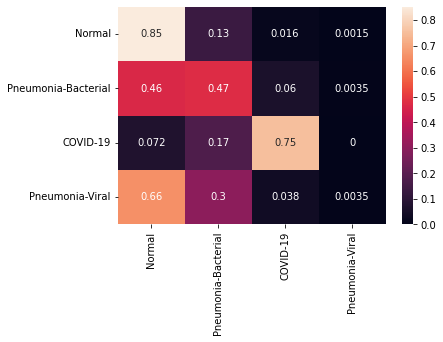

acc,▃▃▃▃▃▂▃▂▃▃▃▄▃▃▃▂▂▂▁▃▃▁▁▂▃▂▂▃▃▃▄▁▅▅▅▅▅█▅▆
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁█
val_loss,█▇▁
acc,0.57812
loss,1.06465
val_acc,0.58092
val_loss,1.03815


In [6]:
#############
# Example run
#############

config = {'dataset' : 'tawsifur',
         'random_seed' : 12,
         'batch_size' : BATCH_SIZE,
         'resolution' : 256}

wandb.init(project='xrays', entity='usp-covid-xrays', reinit=True, config = config)

def basemodel_process(x): return x
test_model = model.train_model("test", net_container, basemodel_process, dataset_mendeley, masks = None, class_names = ['Normal', 'Pneumonia Bacteriana', 'COVID-19', 'Pneumonia Viral'], num_epochs = 3)
y_test_pred = net_container.predict(test_model.params, test_model.state, dataset_mendeley.x_test)
plots.confusion_matrix(dataset_mendeley, y_test_pred, '')

wandb.finish()

In [8]:
import sklearn

def five_fold_cross_validation(model_name, original_dataset, process_fn):
    matrices = []
    for i in range(5):
        cv_dataset = original_dataset.five_fold(i)
        trained_model = model.train_model(model_name + "CV" + str(i), net_container, process_fn, cv_dataset)
        y_test_pred = net_container.predict(trained_model.params, trained_model.state, cv_dataset.x_test)
        matrices.append(sklearn.metrics.confusion_matrix(
                        cv_dataset.y_test[0:y_test_pred.shape[0],].argmax(1),
                        y_test_pred.argmax(1), normalize = 'true'
                    ))
    return matrices

tcmalloc: large alloc 13315866624 bytes == 0x85610a000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x50b868 0x56bc9b
tcmalloc: large alloc 13315866624 bytes == 0x1586bca000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x50b868 0x56bc9b
tcmalloc: large alloc 16644833280 bytes == 0x85610a000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba961

Model saved to models/basemodel_tawsifurCV0.pickle


100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  4.89it/s]
tcmalloc: large alloc 9986899968 bytes == 0x18a16ca000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x50b868 0x56bc9b
tcmalloc: large alloc 9986899968 bytes == 0x1af530a000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x50b868 0x56bc9b
tcmalloc: large alloc 13315866624 bytes == 0x1d4974a000 @  0x7fd6d96d7680 0x7fd6d96f8

Model saved to models/basemodel_tawsifurCV1.pickle


100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.31it/s]
tcmalloc: large alloc 13315866624 bytes == 0x1586bca000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x5f5b33 0x50b7f8
tcmalloc: large alloc 16644833280 bytes == 0x85610a000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x5f5b33 0x50b7f8
100%|███████████████████████████████| 132/132 [00:13<00:00,  9.93it/s, loss=0.00, ac

Model saved to models/basemodel_tawsifurCV2.pickle


100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.43it/s]
tcmalloc: large alloc 9986899968 bytes == 0x18a16ca000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x50b868 0x56bc9b
tcmalloc: large alloc 9986899968 bytes == 0x1af530a000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x50b868 0x56bc9b
tcmalloc: large alloc 13315866624 bytes == 0x1d4974a000 @  0x7fd6d96d7680 0x7fd6d96f8

Model saved to models/basemodel_tawsifurCV3.pickle


100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 16.38it/s]
tcmalloc: large alloc 13315866624 bytes == 0x1586bca000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x50b868 0x56bc9b
tcmalloc: large alloc 13315866624 bytes == 0x85610a000 @  0x7fd6d96d7680 0x7fd6d96f8824 0x7fd6d96f8b8a 0x7fd4b10e36b7 0x7fd4abdda790 0x7fd4abde9414 0x7fd4abdec287 0x7fd4abd37f0f 0x7fd4abaa9be8 0x7fd4aba96166 0x5f2cc9 0x5f3010 0x50bf55 0x56fb87 0x568d9a 0x5f5b33 0x5f5308 0x6655bd 0x5f28fe 0x56c332 0x568d9a 0x5f5b33 0x5f5369 0x6655bd 0x5f28fe 0x56c332 0x5f5956 0x56acb6 0x568d9a 0x50b868 0x56bc9b
tcmalloc: large alloc 16644833280 bytes == 0x2444c0a000 @  0x7fd6d96d7680 0x7fd6d96f

Model saved to models/basemodel_tawsifurCV4.pickle


100%|███████████████████████████████████████████████████████████████████████████████████| 33/33 [00:02<00:00, 14.34it/s]


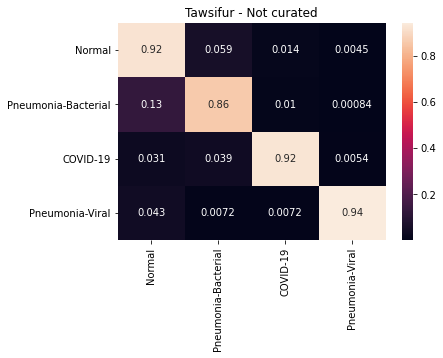

In [11]:
matrices = five_fold_cross_validation("basemodel_tawsifur", dataset_tawsifur, basemodel_process)
plots.heatmatrix(matrices[0], "Tawsifur - Not curated")

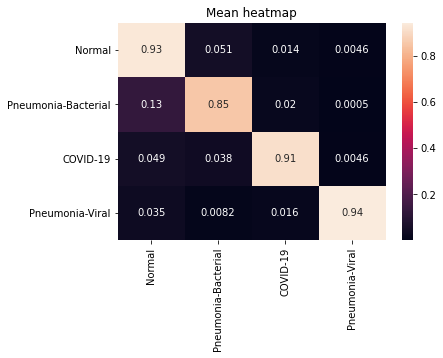

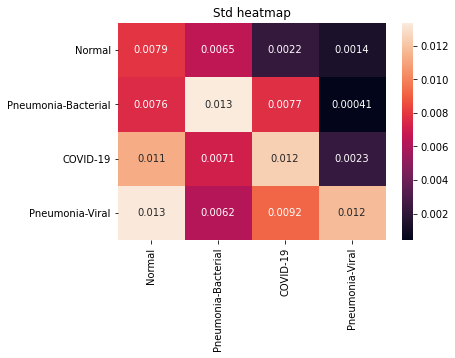

In [14]:
matrices_array = np.asarray(matrices)
plots.heatmatrix(matrices_array.mean(axis=0), "Mean heatmap")
plots.heatmatrix(matrices_array.std(axis=0), "Std heatmap")

In [ ]:
basemodel_tawsifur = model.train_model(model_name + "CV" + str(i), net_container, process_fn, cv_dataset)
sims = trim_duplicates.compute_similarities(dataset_tawsifur, net_container, basemodel_tawsifur)

In [ ]:
thresh = 0.998
max_sims = sims.max(axis=1) - thresh
y_classes = dataset_tawsifur.y_all[:sims.shape[0]].argmax(1)
max_sims_index = sims.argmax(axis=1)
mask = (max_sims >= 0) & (max_sims <= 0.0005)
indices = np.where(mask)[0]
plots.compare_images(dataset_tawsifur.x_all[indices], dataset_tawsifur.x_all[max_sims_index[indices]], rows=10)
#trim_duplicates.plot_similarities(dataset_tawsifur, sims, threshold=0.99)

In [ ]:
trim_duplicates.plot_similarities(dataset_tawsifur, sims, threshold=thresh)
dataset_tawsifur_curated = trim_duplicates.remove_duplicates(dataset_tawsifur, sims, threshold=thresh)

In [ ]:
print(dataset_tawsifur_curated.x_train.shape, dataset_tawsifur.x_train.shape)

In [ ]:
basemodel_tawsifur_curated = model.train_model("basemodel_tawsifur_curated", net_container, basemodel_process, dataset_tawsifur_curated)
y_pred_tawsifur_curated = net_container.predict(basemodel_tawsifur_curated.params, basemodel_tawsifur_curated.state, dataset_tawsifur_curated.x_test)
plots.confusion_matrix(dataset_tawsifur_curated, y_pred_tawsifur_curated, "Tawsifur - Curated")

# Transfer learning test

In [5]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("mendeley", rng=rng)

net, optim = model.init_net_and_optim(dataset_mendeley.x_train, NUM_CLASSES, BATCH_SIZE)

# Gets functions for the model
net_container = network.create(net, optim, BATCH_SIZE, shape = (10, 256, 256, 3))

tcmalloc: large alloc 7241465856 bytes == 0x87e72000 @  0x7f476db50680 0x7f476db71824 0x7f47639974ce 0x7f47639ed00e 0x7f47639edc4f 0x7f4763a8f924 0x5f5db9 0x5f698e 0x57195c 0x56a0ba 0x5f6343 0x56cf2a 0x56a0ba 0x5f6343 0x570e46 0x56a0ba 0x5f6343 0x56cf2a 0x56a0ba 0x68d5b7 0x600f54 0x5c5530 0x56bddd 0x5004f8 0x56d80c 0x5004f8 0x56d80c 0x5004f8 0x5042c6 0x56bf09 0x5f6166
tcmalloc: large alloc 7241465856 bytes == 0x2413ca000 @  0x7f476db50680 0x7f476db71824 0x7f476db71b8a 0x7f454605c6b7 0x7f4540d53790 0x7f4540d62414 0x7f4540d65287 0x7f4540cb0f0f 0x7f4540a22be8 0x7f4540a0f166 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d 0x5f574e 0x56d5f6 0x5f6166 0x56bf09 0x56a0ba 0x50adf0 0x56cf2a 0x56a0ba
tcmalloc: large alloc 7241465856 bytes == 0x3f35a2000 @  0x7f476db50680 0x7f476db71824 0x7f476db71b8a 0x7f454605c6b7 0x7f4540d53790 0x7f4540d62414 0x7f4540d65287 0x7f4540cb0f0f 0x7f4540a22be8 0x7f4540a0f166 0x5f5db9 0x5f698e 0x50b4c7

Model loaded from models/basemodel_tawsifurCV0.pickle


100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00,  7.19it/s]


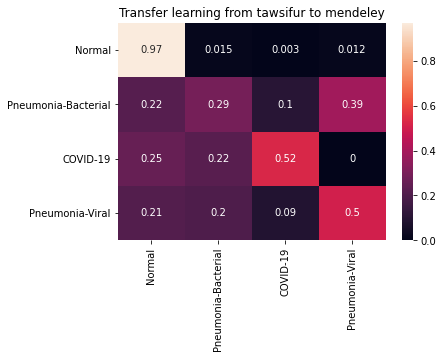

In [13]:
# Test of tawsifur on mendeley

basemodel_tawsifur = model.train_model("basemodel_tawsifurCV0", net_container, basemodel_process, dataset_mendeley)
y_test_pred = net_container.predict(basemodel_tawsifur.params, basemodel_tawsifur.state, dataset_mendeley.x_test)
matrix = sklearn.metrics.confusion_matrix(
        dataset_mendeley.y_test[0:y_test_pred.shape[0],].argmax(1),
        y_test_pred.argmax(1), normalize = 'true'
    )
plots.heatmatrix(matrix, "Transfer learning from tawsifur to mendeley")